***
***
***

# **Net-zero multi-energy systems.**


***
***
***

## Indice

- [1. Introducción](#sec1)
- [2. Descripción de la Base de Datos](#sec2)
- [3. Análisis de Variables](#sec3)
    - [3.1. Análisis Univariado según el tipo de tecnología](#sec3-1)
        - [3.1.1. SFV - Solar Fotovoltaica](#sec3-1-1)
        - [3.1.2. H - Hidroélectrica](#sec3-1-2)
        - [3.1.3. O - Otros](#sec3-1-3)
        - [3.1.4. I - Interconexión a otro país](#sec3-1-4)
        - [3.1.5. B - Biomasa](#sec3-1-5)
        - [3.1.6. Conclusiones](#sec3-1-6)
    - [3.2. Análisis Multivariado de la Varianza](#sec3-2)
- [4. Otras Visualizaciones](#secvisual)
- [5. Conclusiones](#sec4)

***
***
***

## 1. Introducción <a id='sec1'></a>

La energía es uno de los principales recursos para los seres humanos. Por desgracia las formas de obtención y uso han causado un gran impacto ambiental, generando la necesidad de crear sistemas de energías sostenibles y de cero emisiones. Estos buscan reemplazar los métodos tradicionales, como lo son la solar fotovoltaica, hidráulica, eólica o biomasa. Por sus características, se suelen emplear para cubrir las necesidades energéticas de áreas rurales e independientes, pues son estas áreas las que tienen mayor dificultad para lograr acceder a las fuentes de energía tradicional.


Este documento se enfoca en el análisis de la base de datos [Registros de Operación](https://www.datos.gov.co/Minas-y-Energ-a/Superservicios-Registro-De-Operaci-n-Diario-Otro-T/bsnu-ddmp). Por medio de la identificación de patrones, características y correlaciones según el área o los tipos de tecnología, se busca mejorar la toma de decisiones y la según el tipo de tecnología. Así se logra contribuir a la planeación y creación de sistemas energéticos de cero emisiones, con un modelo efectivo y eficiente, que representa la realidad en las áreas rurales e independientes.

Con el fin de lograr esto, se utilizo la plataforma de Google Colab, la base de datos [Departamentos y Municipios de Colombia](https://www.datos.gov.co/Mapas-Nacionales/Departamentos-y-municipios-de-Colombia/xdk5-pm3f), la libreria [GeoJSON](https://github.com/deldersveld/topojson/blob/master/countries/colombia/colombia-departments.json) y las siguientes librerias:

In [1]:
import pandas as pd                                     # pip install pandas
import matplotlib                                       # pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np                                      # pip install numpy
from datetime import datetime
import seaborn as sns                                   # pip install seaborn
import os
import json
import plotly.express as px                                 # pip install plotly nbformat
import plotly
from IPython.display import Image

```
pip install pandas matplotlib numpy seaborn plotly nbformat plot_utils -U kaleido
```

***
***
***

## 2. Descripción de la base de datos <a id='sec2'></a>

En la base de datos [Registros de Operación](https://www.datos.gov.co/Minas-y-Energ-a/Superservicios-Registro-De-Operaci-n-Diario-Otro-T/bsnu-ddmp) se encuentran las siguientes columnas:

- **_Código Localidad_**: Corresponde a la división político-administrativa de Colombia con la siguiente estructura _DDMMMCCC_ + _LLLLL_ consecutivo del código asignado SSPD. Donde _DD_ es el código del Departamento, _MMM_ corresponde al código Municipio, _CCC_ corresponde al código del Centro Poblado. Si la localidad no se encuentra en la codificación DANE se registra el campo de la Cabecera Municipal. Además de _LLLLL_, consecutivo asignado por la SSPD.

- **_Tipo de Tecnología_**: Corresponde a la codificación según el tipo de tecnología utilizada para generar (entregar) energía en la localidad y está dada por la siguiente tabla: _H_ Hidroélectrica, _B_ Biomasa, _E_ Eólica, _TG_ Térmica a Gas, _TC_ Térmica a Carbón, _TBG_ Térmica a Biogás, _I_ Interconexión a otro país, _SFV_ Solar Fotovoltaica y _O_ que corresponde a Otros.

- **_Kms de Red Interconexión_**: Corresponde a los kilómetros de subtransmisión existentes para interconectar dos mercados ZNI.

- **_Capacidad (kW)_**: Corresponde a la capacidad existente en la central eléctrica. *En el caso de Interconexiones este campo se debe estar vacío*.

- **_Fecha_**: Se refiere a la fecha en que fue prestado el servicio y de la cual se están reportando los datos de operación de la central de generación o la interconexión.

- **_Horas de Servicio_**: Corresponde al número de horas diarias que prestó el servicio en la fecha señalada.

- **_Energía Entregada (kWh)_**: Corresponde a la lectura real de la Energía generada en el día. Para el caso de una interconexión eléctrica debe ser la energía activa medida cuyo dato es tomado la frontera comercial o en el punto de entrega de energía al Distribuidor comercializador.

- **_ID Empresa_**, **_Nombre_**, **_Periodo_** y **_Anio_**: Otras variables presentes el la base de datos.

Para este análisis se consideran las variables más importantes para la extracción de datos útiles para predecir la demanda de energía en un sistema NZES, el cual se basa en el axioma de que la demanda de energía se cubre con energía generada in situ y activos de almacenamiento de energía. Las variables seleccionadas son: **_Código Localidad_**, **_Tipo de Tecnología_**, **_Kms de Red Interconexión_**, **_Capacidad (kW)_**, **_Fecha_**, **_Horas de Servicio_** y **_Energía Entregada (kWh)_**. Estas variables permitirán entender la capacidad de generación y suministro de energía en una zona determinada y podrán ayudar en el dimensionamiento óptimo de los sistemas de almacenamiento de energía necesarios para garantizar la suficiencia energética en una zona rural de NZES.

In [15]:
df = pd.read_csv('resources/DB_Superservicios-Registro_De_Operacion_Diario.csv')
df = df.drop(['ID_EMPRESA', 'NOMBRE', 'PERIODO', 'ANIO'], axis=1)

Dado que la columna **_Código Localidad_** es compuesta, se extraeran los datos particulares del Departamento _DD_ y el Municipio _DDMMM_ acorde a los codigos establecidos por el Departamento Administrativo Nacional de Estadística (DANE).

In [16]:
df['Departamento'] = df['Código Localidad']// 100000000000
df['Municipio'] = df['Código Localidad']// 100000000
df = df.drop(['Código Localidad'], axis=1)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Horas de Servicio'] = pd.to_datetime(df['Horas de Servicio'], format='%H:%M')
df['Fecha'] = df['Fecha'].apply(lambda x: x.timestamp())
df['Horas de Servicio'] = df['Horas de Servicio'].apply(lambda x: x.timestamp())

df.info()

C:\Users\Laura\AppData\Local\Temp\ipykernel_3796\2911817471.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200220 entries, 0 to 200219
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Tipo de Tecnología        200220 non-null  object 
 1   kms de Red Interconexión  200220 non-null  int64  
 2   Capacidad (kW)            196190 non-null  float64
 3   Fecha                     200220 non-null  float64
 4   Horas de Servicio         200220 non-null  float64
 5   Energía Entregada (kWh)   200220 non-null  float64
 6   Departamento              200220 non-null  int64  
 7   Municipio                 200220 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 12.2+ MB


In [6]:
df.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)         Fecha   
0                  O                         1           125.0  1.504915e+09  \
1                  O                         1           125.0  1.502237e+09   
2                  O                         1           125.0  1.499558e+09   
3                  O                         1           125.0  1.504829e+09   
4                  O                         1           125.0  1.502150e+09   

   Horas de Servicio  Energía Entregada (kWh)  Departamento  Municipio  
0      -2.208971e+09                    169.0            99      99524  
1      -2.208971e+09                    168.0            99      99524  
2      -2.208971e+09                    167.0            99      99524  
3      -2.208971e+09                    168.0            99      99524  
4      -2.208971e+09                    167.0            99      99524

In [7]:
df[['kms de Red Interconexión', 'Capacidad (kW)', 'Fecha', 'Horas de Servicio', 'Energía Entregada (kWh)',]].describe()

kms de Red Interconexión  Capacidad (kW)         Fecha   
count              200220.00000   196190.000000  2.002200e+05  \
mean                   32.56401      993.109638  1.589596e+09   
std                   337.96059     1369.650422  3.971016e+07   
min                     0.00000        0.000000  1.498867e+09   
25%                     0.00000        0.860000  1.562717e+09   
50%                     0.00000      625.000000  1.598746e+09   
75%                     0.00000     1540.000000  1.619827e+09   
max                  3647.00000    11250.000000  1.648685e+09   

       Horas de Servicio  Energía Entregada (kWh)  
count       2.002200e+05             2.002200e+05  
mean       -2.208948e+09             3.589457e+03  
std         3.345731e+04             2.170395e+05  
min        -2.208989e+09             0.000000e+00  
25%        -2.208974e+09             3.470000e+00  
50%        -2.208974e+09             7.800000e+00  
75%        -2.208902e+09             1.190400e+02  
max        -2.208902e+09             4.682271e+07

In [8]:
for columns in df.columns:
    print('\n','Información sobre la columna: ', columns )
    print(df[columns].value_counts(),"\n")


 Información sobre la columna:  Tipo de Tecnología
Tipo de Tecnología
SFV    179605
H       12987
O        4812
I        2542
B         274
Name: count, dtype: int64 


 Información sobre la columna:  kms de Red Interconexión
kms de Red Interconexión
0       184778
1        11136
3646      1733
175        653
2          457
13         365
33         365
35         365
4          184
225        183
3647         1
Name: count, dtype: int64 


 Información sobre la columna:  Capacidad (kW)
Capacidad (kW)
0.86       19956
0.53       10563
1120.00     6744
1200.00     6744
0.78        6040
           ...  
15.12          9
14.04          9
59.00          3
299.00         3
110.00         3
Name: count, Length: 145, dtype: int64 


 Información sobre la columna:  Fecha
Fecha
1.640995e+09    6858
1.646093e+09    6858
1.643674e+09    6858
1.609459e+09    6826
1.601510e+09    6731
                ... 
1.523837e+09       9
1.522541e+09       9
1.525219e+09       9
1.523578e+09       9
1.526083e

Note que para este caso, se tienen las variables categóricas: **_Tipo de Tecnología_**, **_Departamento_** y **_Municipio_**. Además las numericas: **_kms de Red Interconexión_**, **_Capacidad (kW)_**, **_Fecha_**, **_Horas de Servicio_** y **_Energía Entregada (kWh)_** . Para poder comparar mejor las numéricas, se normalizan estas variables.

In [9]:
df_normalized = df.copy()
for column in df_normalized[['kms de Red Interconexión', 'Capacidad (kW)', 'Energía Entregada (kWh)']].columns:
    mean = np.mean(df_normalized[column])
    std = np.std(df_normalized[column])
    df_normalized[column] = (df_normalized[column] - mean) / std

df_normalized['Fecha'] = (df['Fecha'] - df['Fecha'].min()) / (df['Fecha'].max() - df['Fecha'].min())
df_normalized['Horas de Servicio'] = (df['Horas de Servicio'] - df['Horas de Servicio'].min()) / (df['Horas de Servicio'].max() - df['Horas de Servicio'].min())

df_normalized.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)     Fecha   
0                  O                 -0.093396        -0.63382  0.040369  \
1                  O                 -0.093396        -0.63382  0.022491   
2                  O                 -0.093396        -0.63382  0.004614   
3                  O                 -0.093396        -0.63382  0.039792   
4                  O                 -0.093396        -0.63382  0.021915   

   Horas de Servicio  Energía Entregada (kWh)  Departamento  Municipio  
0           0.207232                -0.015760            99      99524  
1           0.207232                -0.015764            99      99524  
2           0.207232                -0.015769            99      99524  
3           0.207232                -0.015764            99      99524  
4           0.207232                -0.015769            99      99524

Si se desea volver a obtener las fechas y no los numeros, se puede utilizar

```
df['Fecha_de_numeros'] = df['Fecha_en_numeros'].apply(lambda x: pd.Timestamp.fromtimestamp(x))
df['Horas_de_Servicio_de_numeros'] = df['Horas_de_Servicio_en_numeros'].apply(lambda x: pd.Timestamp.fromtimestamp(x))
```

***
***
***
## 3. Análisis de Variables <a id='sec3'></a>

Es importante tener en cuenta que los datos no agrupados pueden no tener una correlación clara entre sí, especialmente cuando se trata de diferentes tipos de tecnologías. Por lo tanto, es necesario realizar un análisis separado para cada tipo de tecnología con el fin de identificar patrones específicos y obtener una comprensión más precisa de los datos.

***
***
### 3.1 Análisis Univariado según el tipo de tecnología <a id='sec3-1'></a>

In [10]:
df_sfv = df[df['Tipo de Tecnología'] == 'SFV']
df_h = df[df['Tipo de Tecnología'] == 'H']
df_o = df[df['Tipo de Tecnología'] == 'O']
df_i = df[df['Tipo de Tecnología'] == 'I']
df_b = df[df['Tipo de Tecnología'] == 'B']

df_sfv_n = df_normalized[df_normalized['Tipo de Tecnología'] == 'SFV']
df_h_n = df_normalized[df_normalized['Tipo de Tecnología'] == 'H']
df_o_n = df_normalized[df_normalized['Tipo de Tecnología'] == 'O']
df_i_n = df_normalized[df_normalized['Tipo de Tecnología'] == 'I']
df_b_n = df_normalized[df_normalized['Tipo de Tecnología'] == 'B']

***

#### 3.1.1: SFV - Solar Fotovoltaica  <a id='sec3-1-1'></a>

In [11]:
df_sfv.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)   
736                SFV                         1            13.5  \
737                SFV                         1             9.6   
738                SFV                         1            11.7   
740                SFV                         1            13.5   
743                SFV                         1            13.5   

            Fecha  Horas de Servicio  Energía Entregada (kWh)  Departamento   
736  1.570838e+09      -2.208931e+09                    54.39            91  \
737  1.527466e+09      -2.208946e+09                    24.39            91   
738  1.509840e+09      -2.208931e+09                    45.66            91   
740  1.569456e+09      -2.208931e+09                    42.27            91   
743  1.536710e+09      -2.208931e+09                    39.37            91   

     Municipio  
736      91001  
737      91001  
738      91001  
740      91001  
743      91001

In [12]:
df_sfv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179605 entries, 736 to 200219
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Tipo de Tecnología        179605 non-null  object 
 1   kms de Red Interconexión  179605 non-null  int64  
 2   Capacidad (kW)            179605 non-null  float64
 3   Fecha                     179605 non-null  float64
 4   Horas de Servicio         179605 non-null  float64
 5   Energía Entregada (kWh)   179605 non-null  float64
 6   Departamento              179605 non-null  int64  
 7   Municipio                 179605 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 12.3+ MB


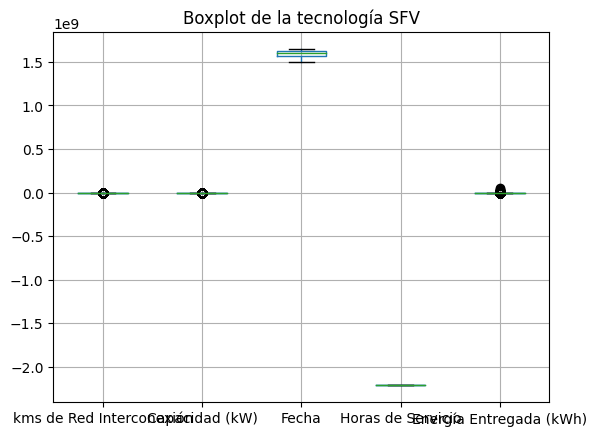

In [13]:
df_sfv.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología SFV')
plt.show()

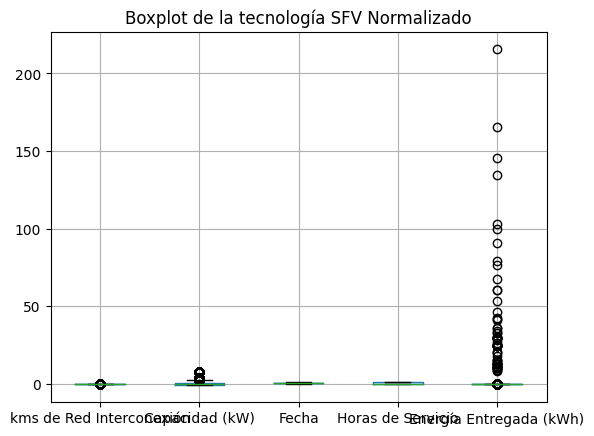

In [14]:
df_sfv_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología SFV Normalizado')
plt.show()

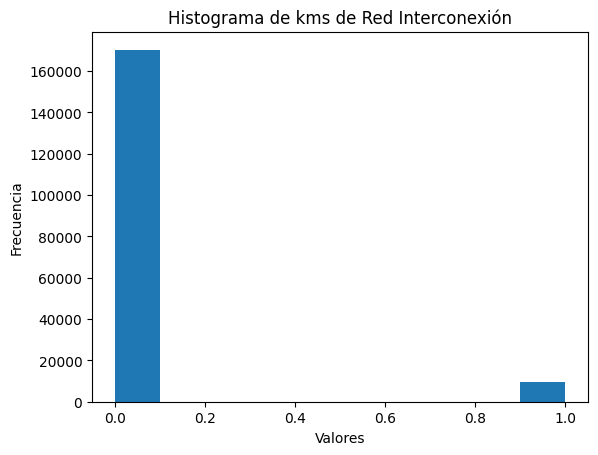

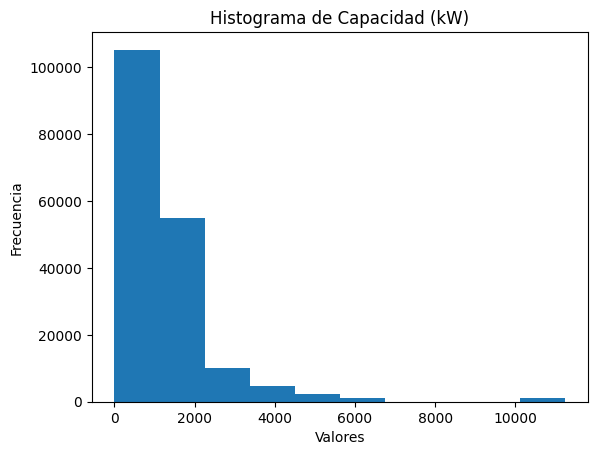

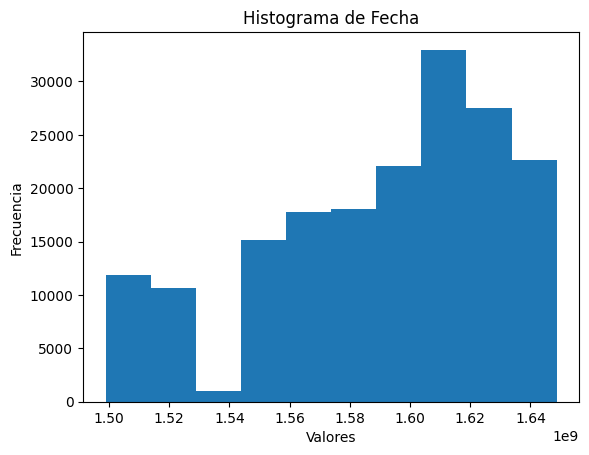

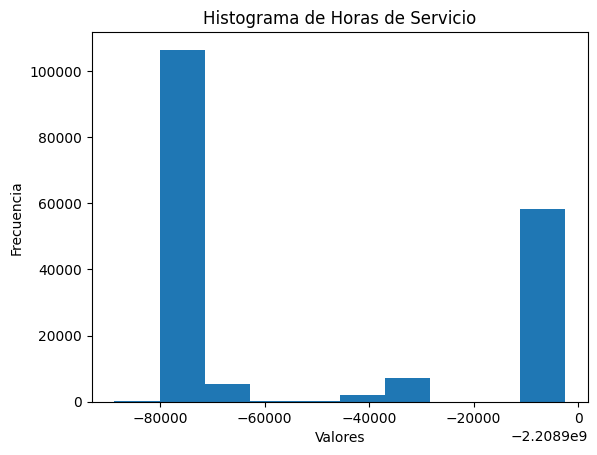

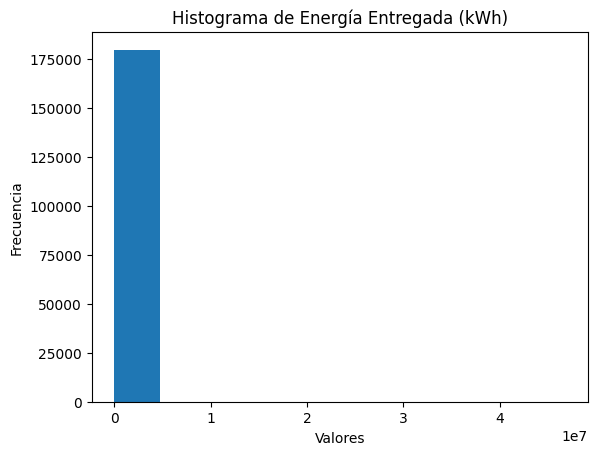

In [15]:
for col in df_sfv.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_sfv[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

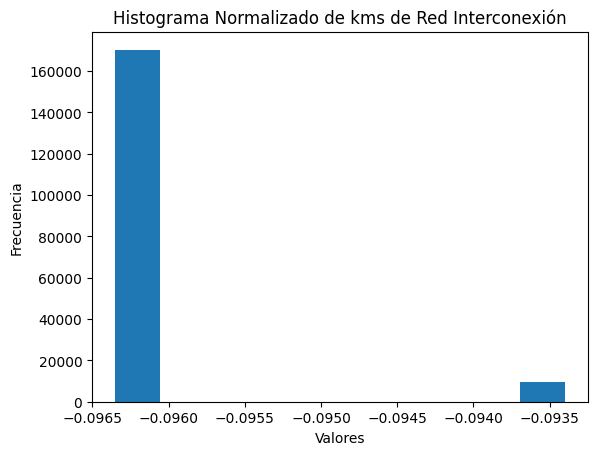

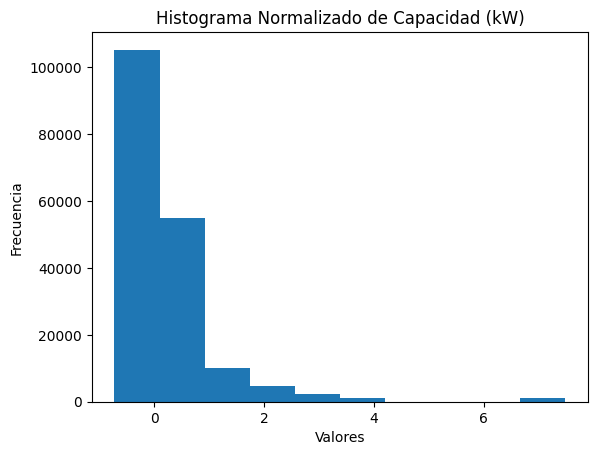

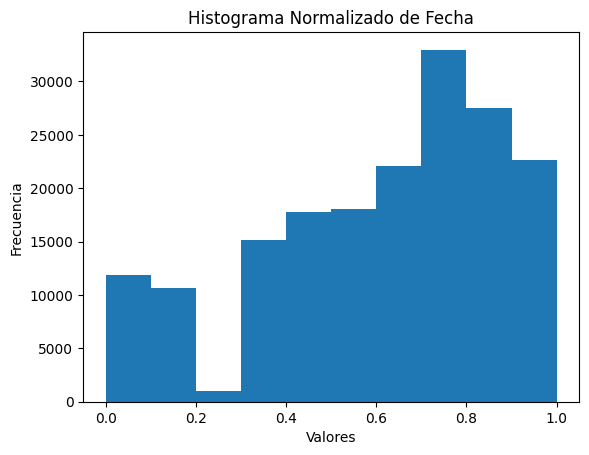

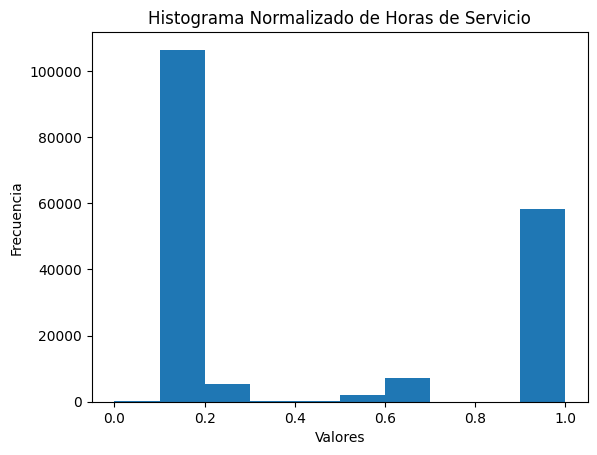

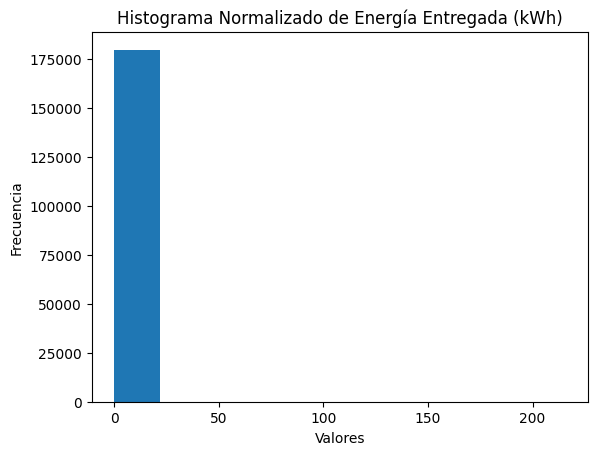

In [16]:
for col in df_sfv_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_sfv_n[col], bins=10)
    plt.title(f"Histograma Normalizado de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

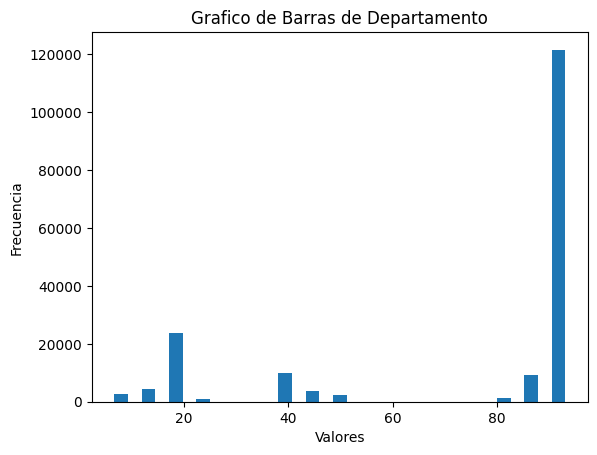

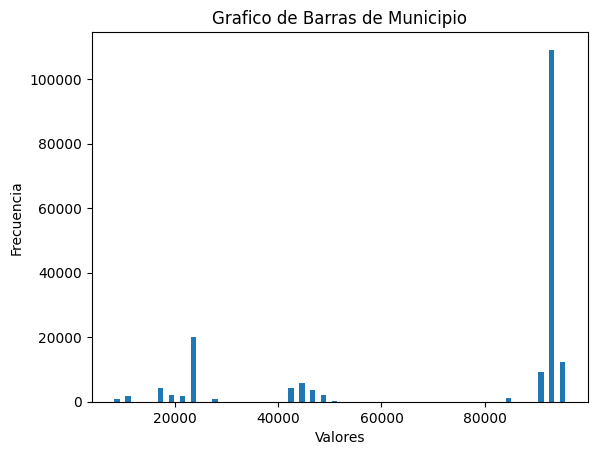

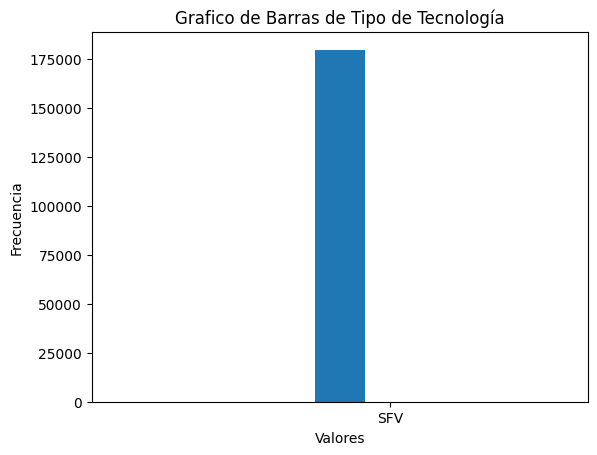

In [17]:
for col in df_sfv.loc[:,['Departamento','Municipio', 'Tipo de Tecnología']].columns:
    plt.hist(df_sfv[col], bins=len(df[col].unique()), align='left', rwidth=0.5)
    plt.title(f"Grafico de Barras de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

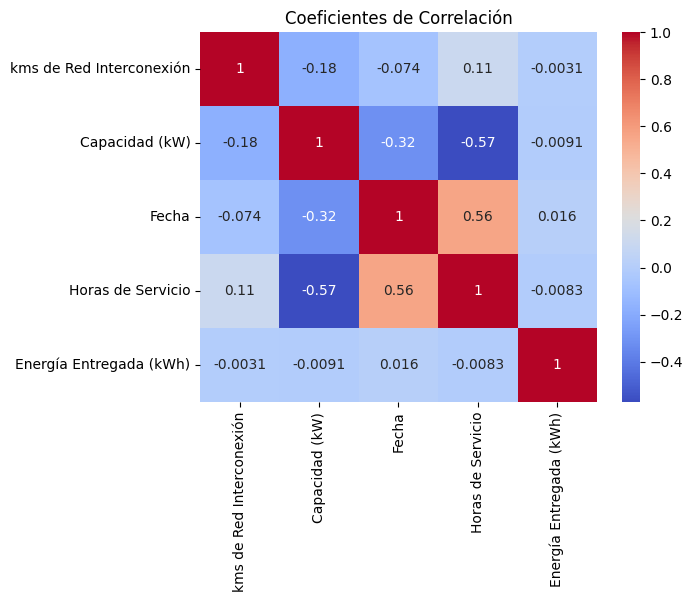

In [18]:
corr_matrix = df_sfv.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Coeficientes de Correlación')
plt.show()

In [19]:
df_sfv.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Index: 179605 entries, 736 to 200219
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   kms de Red Interconexión  179605 non-null  int64  
 1   Capacidad (kW)            179605 non-null  float64
 2   Fecha                     179605 non-null  float64
 3   Horas de Servicio         179605 non-null  float64
 4   Energía Entregada (kWh)   179605 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 8.2 MB


***

####  3.1.2: H - Hidroélectrica  <a id='sec3-1-2'></a>

In [20]:
df_h.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)   
742                  H                         0            32.0  \
762                  H                         0            32.0   
769                  H                         0            32.0   
776                  H                         0            32.0   
782                  H                         0            32.0   

            Fecha  Horas de Servicio  Energía Entregada (kWh)  Departamento   
742  1.564272e+09      -2.208917e+09                    172.0            27  \
762  1.537574e+09      -2.208902e+09                    258.0            27   
769  1.567469e+09      -2.208902e+09                    260.0            27   
776  1.571616e+09      -2.208902e+09                    266.0            27   
782  1.530403e+09      -2.208902e+09                    264.0            27   

     Municipio  
742      27495  
762      27495  
769      27495  
776      27495  
782      27495

In [21]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12987 entries, 742 to 200075
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo de Tecnología        12987 non-null  object 
 1   kms de Red Interconexión  12987 non-null  int64  
 2   Capacidad (kW)            12987 non-null  float64
 3   Fecha                     12987 non-null  float64
 4   Horas de Servicio         12987 non-null  float64
 5   Energía Entregada (kWh)   12987 non-null  float64
 6   Departamento              12987 non-null  int64  
 7   Municipio                 12987 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 913.1+ KB


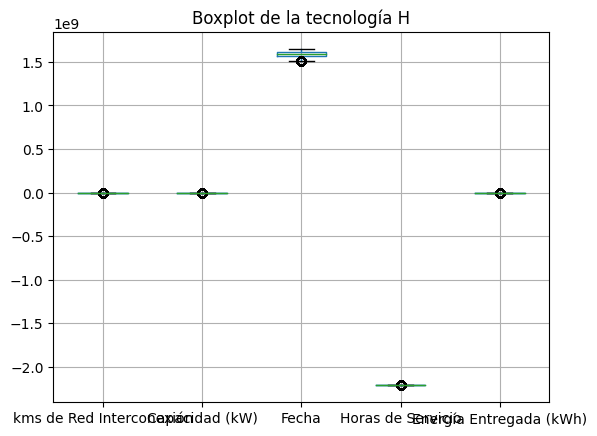

In [22]:
df_h.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología H')
plt.show()

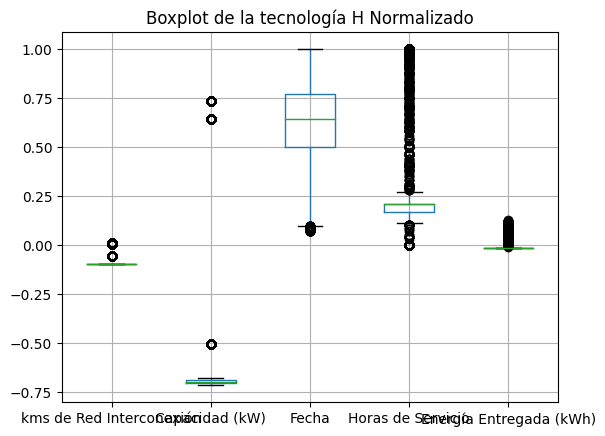

In [23]:
df_h_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología H Normalizado')
plt.show()

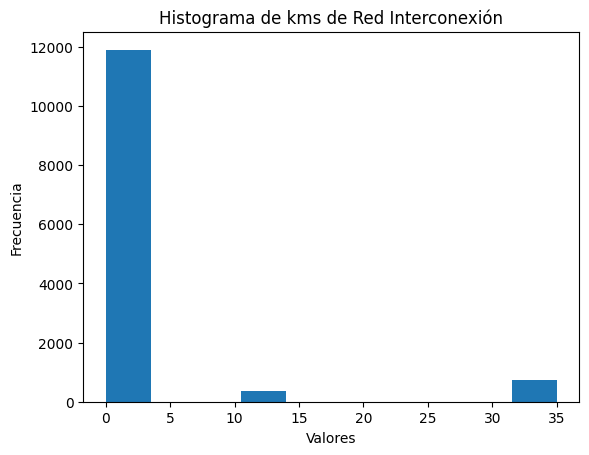

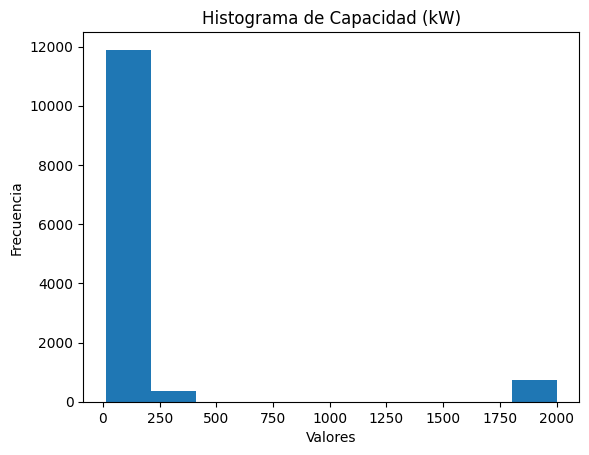

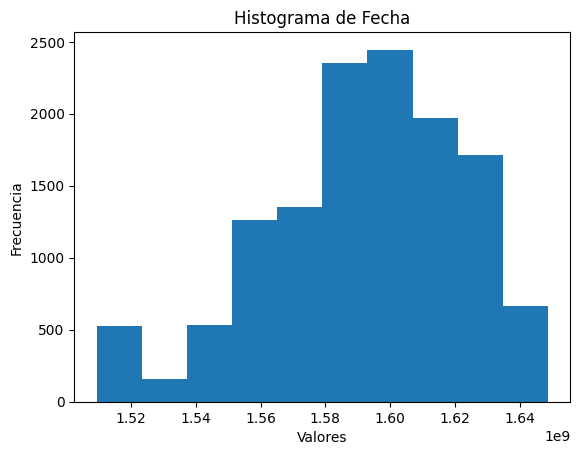

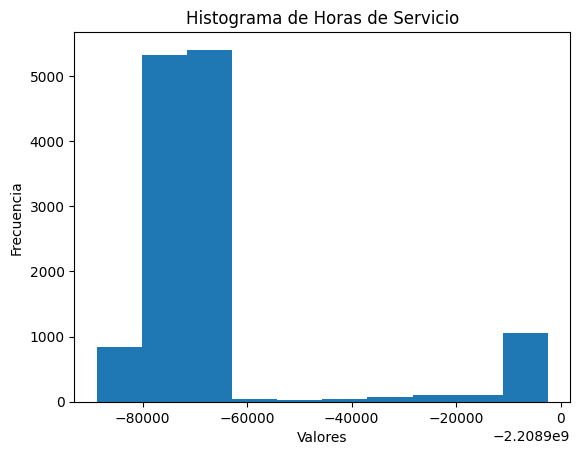

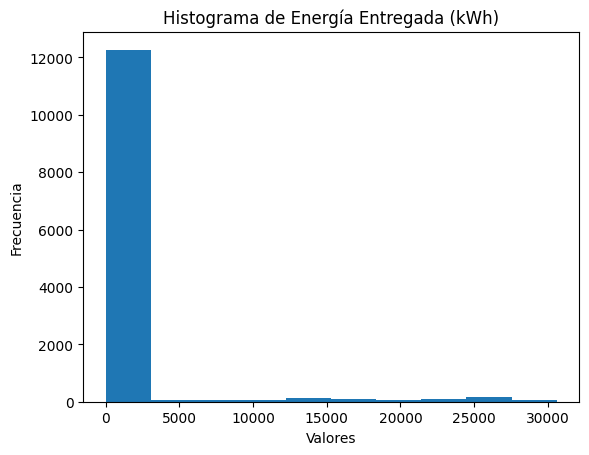

In [24]:
for col in df_h.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_h[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

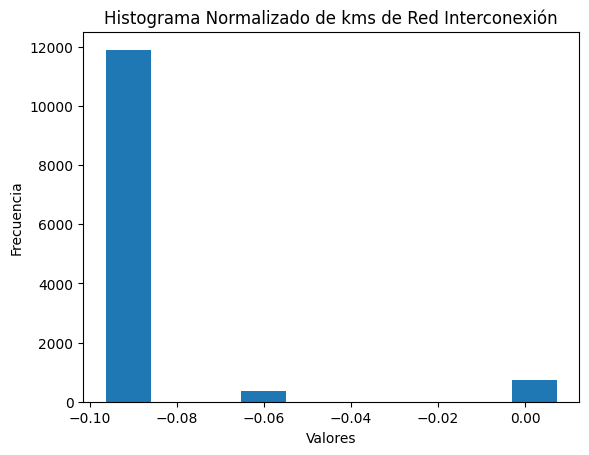

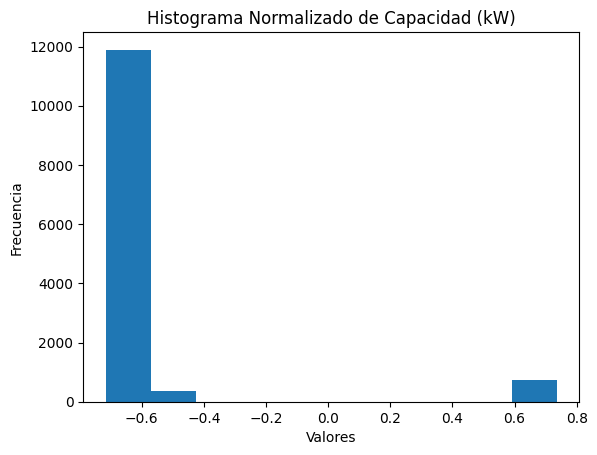

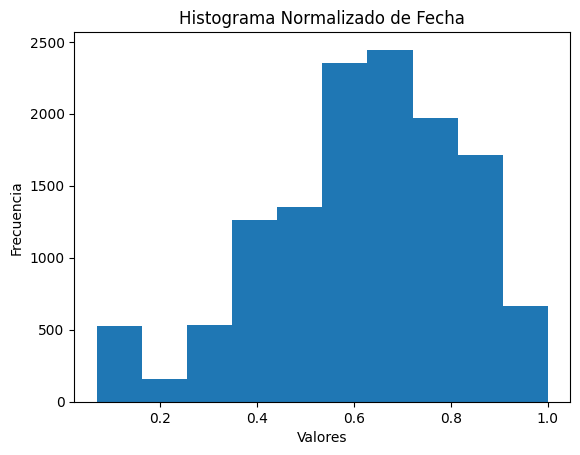

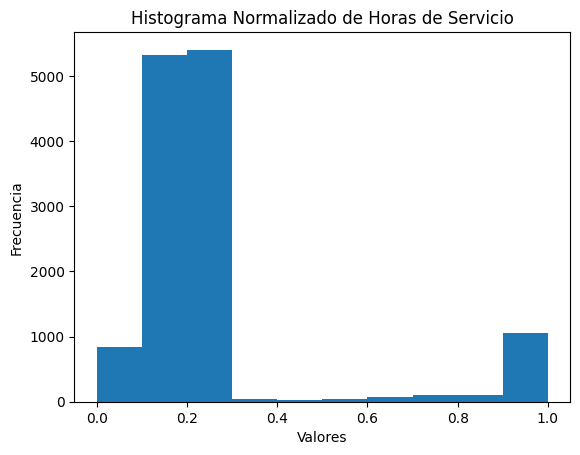

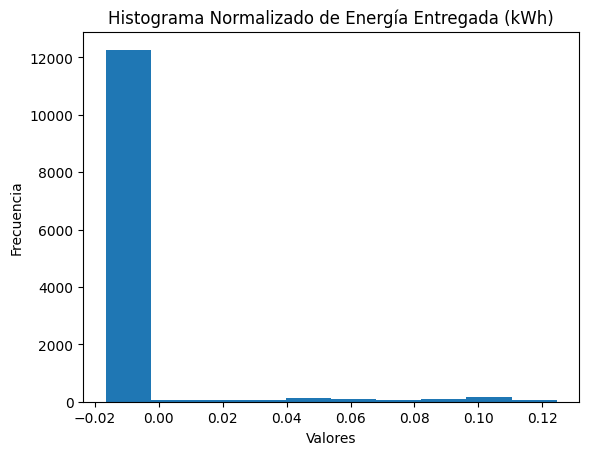

In [25]:
for col in df_h_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_h_n[col], bins=10)
    plt.title(f"Histograma Normalizado de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

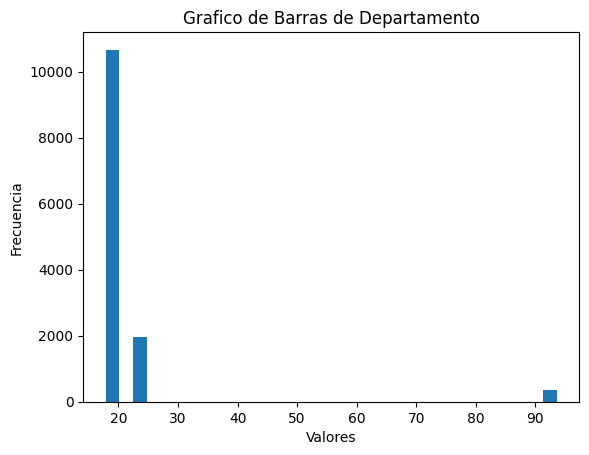

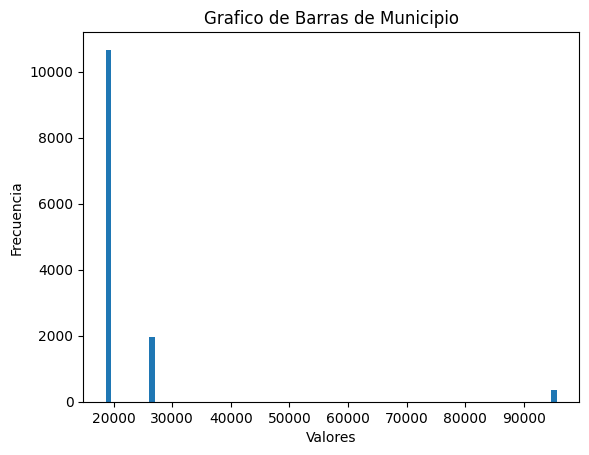

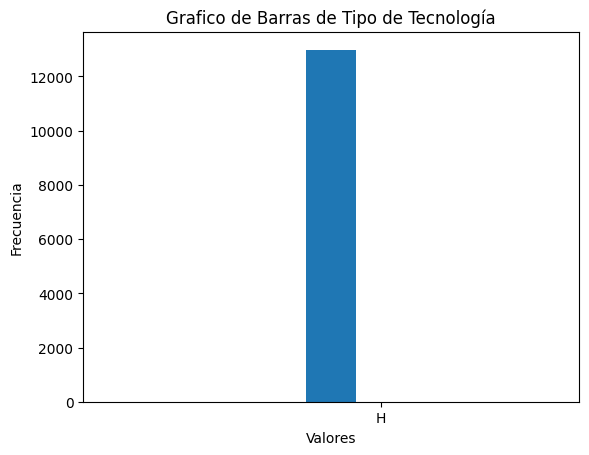

In [26]:
for col in df_h.loc[:,['Departamento','Municipio', 'Tipo de Tecnología']].columns:
    plt.hist(df_h[col], bins=len(df[col].unique()), align='left', rwidth=0.5)
    plt.title(f"Grafico de Barras de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()


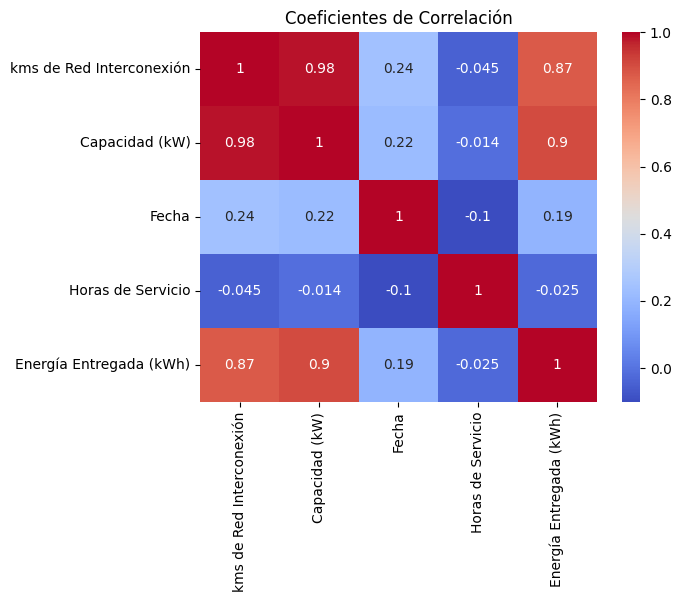

In [27]:
corr_matrix = df_h.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Coeficientes de Correlación')
plt.show()

***

#### 3.1.3: O - Otros  <a id='sec3-1-3'></a>

In [28]:
df_o.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)         Fecha   
0                  O                         1           125.0  1.504915e+09  \
1                  O                         1           125.0  1.502237e+09   
2                  O                         1           125.0  1.499558e+09   
3                  O                         1           125.0  1.504829e+09   
4                  O                         1           125.0  1.502150e+09   

   Horas de Servicio  Energía Entregada (kWh)  Departamento  Municipio  
0      -2.208971e+09                    169.0            99      99524  
1      -2.208971e+09                    168.0            99      99524  
2      -2.208971e+09                    167.0            99      99524  
3      -2.208971e+09                    168.0            99      99524  
4      -2.208971e+09                    167.0            99      99524

In [29]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4812 entries, 0 to 200214
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo de Tecnología        4812 non-null   object 
 1   kms de Red Interconexión  4812 non-null   int64  
 2   Capacidad (kW)            3598 non-null   float64
 3   Fecha                     4812 non-null   float64
 4   Horas de Servicio         4812 non-null   float64
 5   Energía Entregada (kWh)   4812 non-null   float64
 6   Departamento              4812 non-null   int64  
 7   Municipio                 4812 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 338.3+ KB


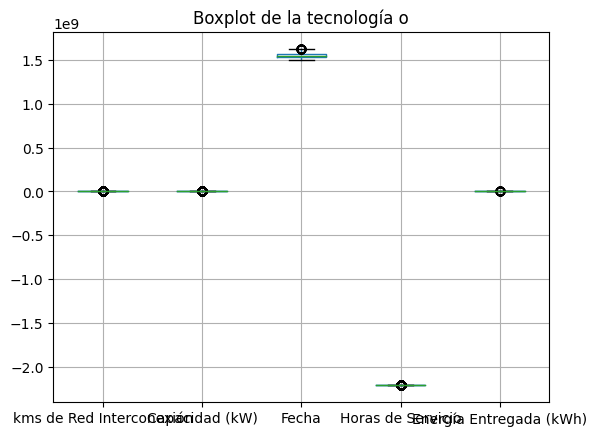

In [30]:
df_o.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología o')
plt.show()

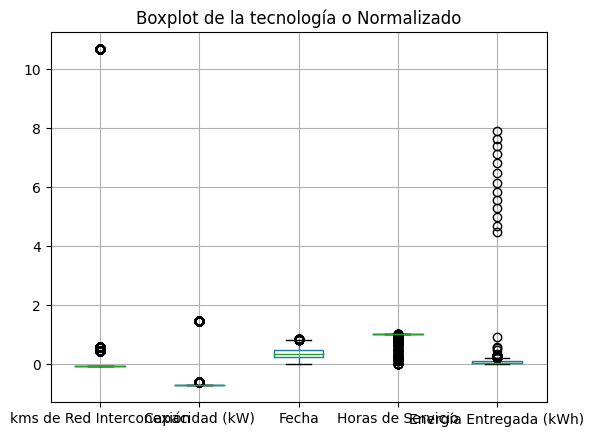

In [31]:
df_o_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).boxplot().set_title('Boxplot de la tecnología o Normalizado')
plt.show()

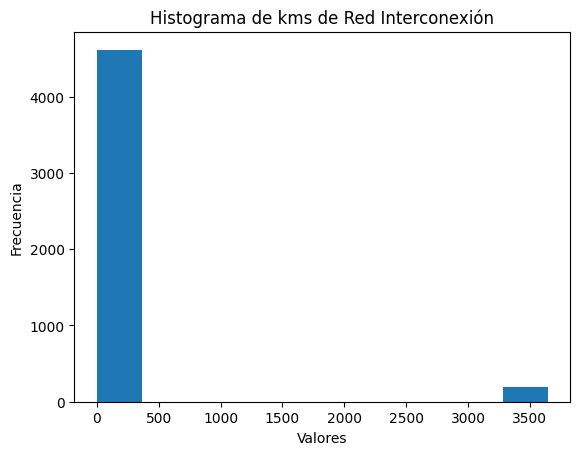

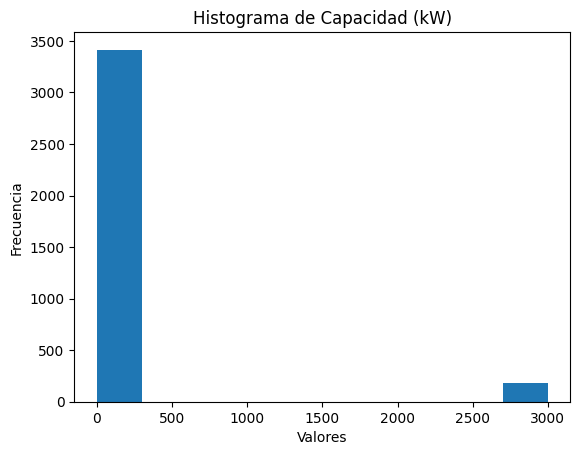

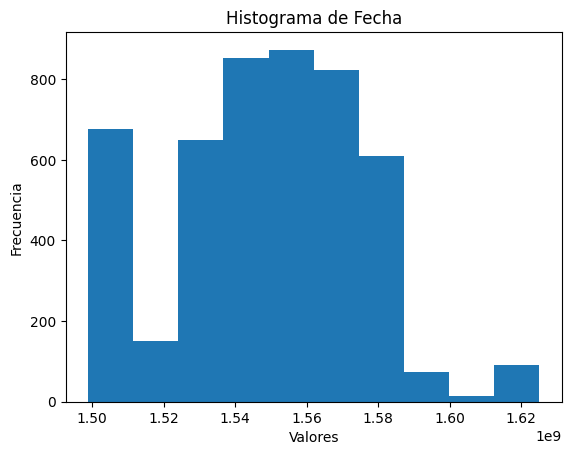

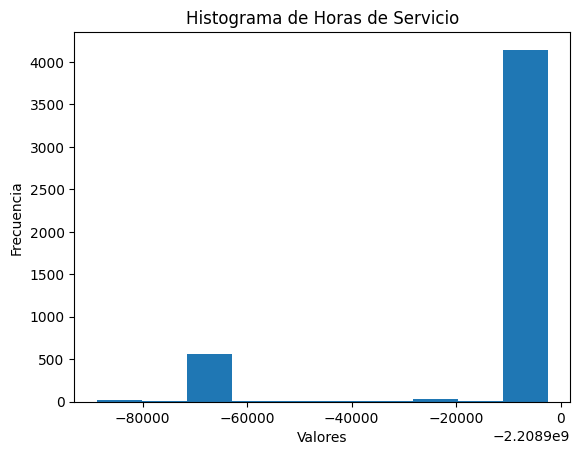

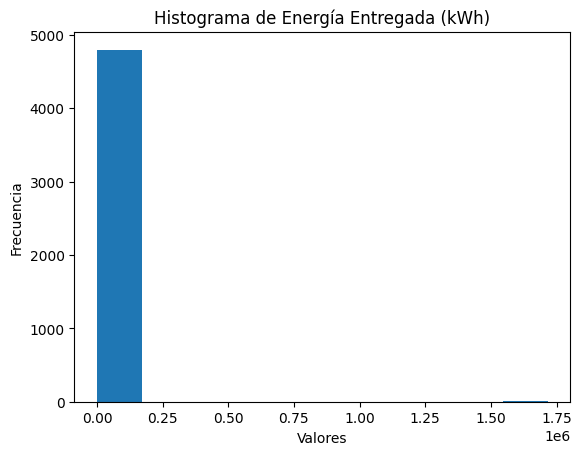

In [32]:
for col in df_o.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_o[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

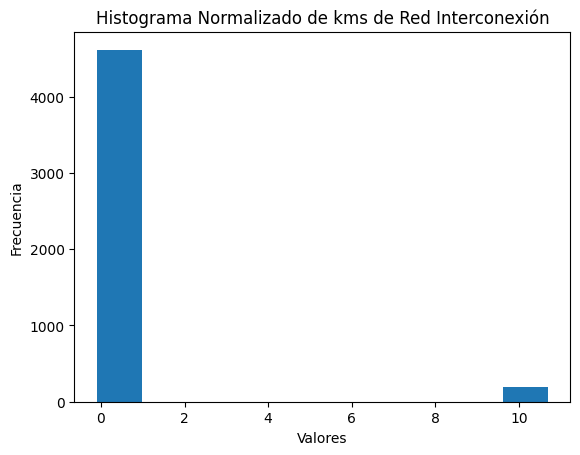

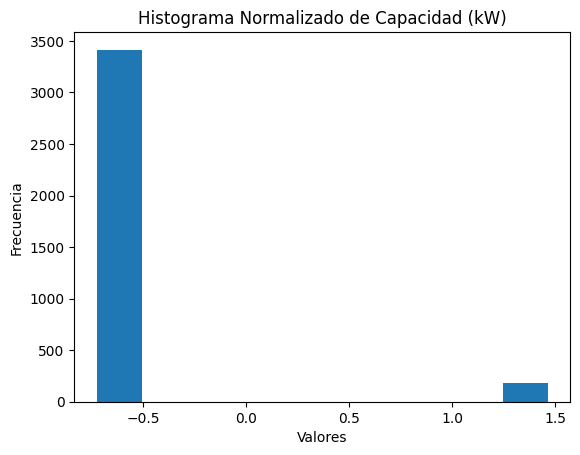

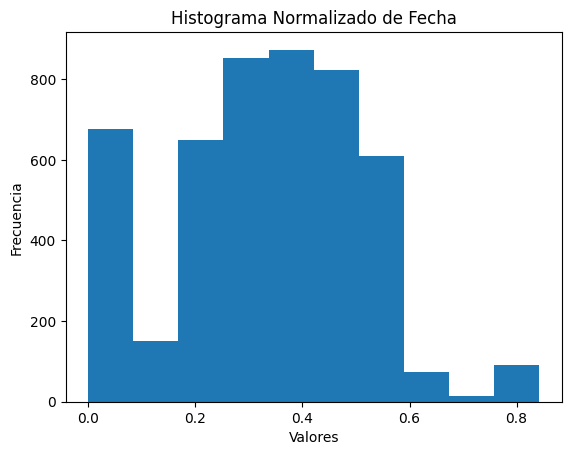

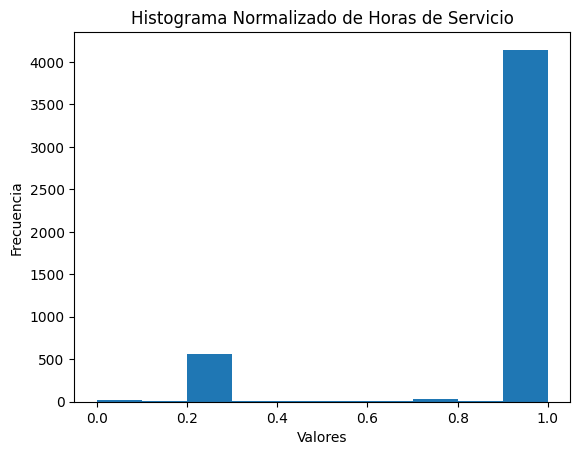

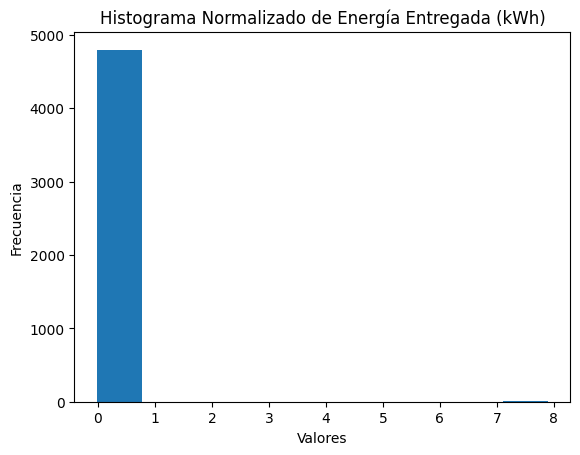

In [33]:
for col in df_o_n.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_o_n[col], bins=10)
    plt.title(f"Histograma Normalizado de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

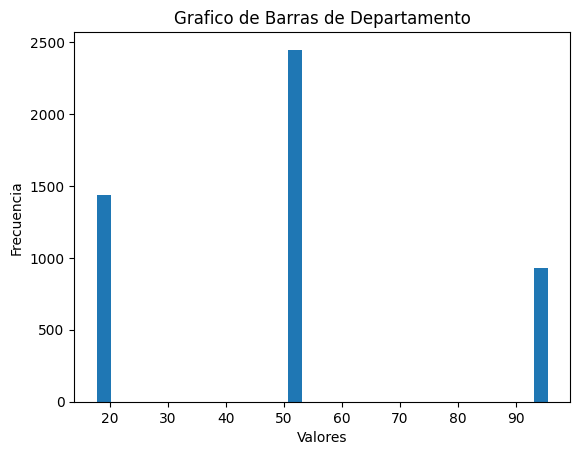

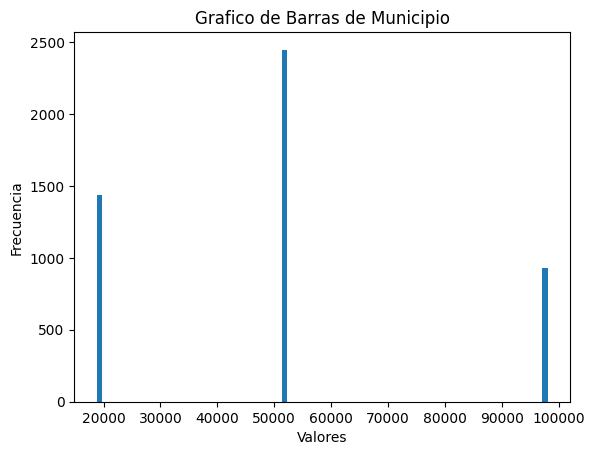

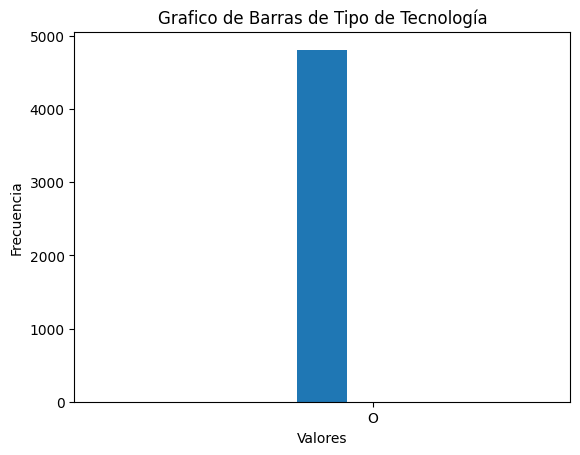

In [34]:
for col in df_o.loc[:,['Departamento','Municipio', 'Tipo de Tecnología']].columns:
    plt.hist(df_o[col], bins=len(df[col].unique()), align='left', rwidth=0.5)
    plt.title(f"Grafico de Barras de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

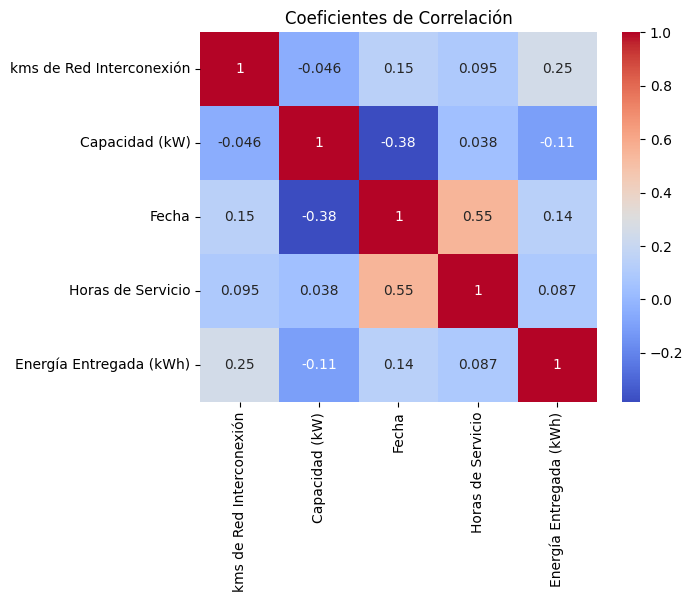

In [35]:
corr_matrix = df_o.drop(['Departamento','Municipio', 'Tipo de Tecnología'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Coeficientes de Correlación')
plt.show()

***

#### 3.1.4: I - Interconexión a otro país <a id='sec3-1-4'></a>

In [36]:
df_i.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)   
739                  I                      3646             NaN  \
741                  I                      3646             NaN   
751                  I                      3646             NaN   
757                  I                      3646             NaN   
763                  I                      3646             NaN   

            Fecha  Horas de Servicio  Energía Entregada (kWh)  Departamento   
739  1.510013e+09      -2.208902e+09                 62374.00            99  \
741  1.567296e+09      -2.208902e+09                 16143.41            99   
751  1.513814e+09      -2.208902e+09                 66343.00            99   
757  1.527638e+09      -2.208902e+09                 70116.50            99   
763  1.535069e+09      -2.208910e+09                 40984.50            99   

     Municipio  
739      99001  
741      99001  
751      99001  
757      99001  
763      99001

In [37]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 739 to 178277
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo de Tecnología        2542 non-null   object 
 1   kms de Red Interconexión  2542 non-null   int64  
 2   Capacidad (kW)            0 non-null      float64
 3   Fecha                     2542 non-null   float64
 4   Horas de Servicio         2542 non-null   float64
 5   Energía Entregada (kWh)   2542 non-null   float64
 6   Departamento              2542 non-null   int64  
 7   Municipio                 2542 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 178.7+ KB


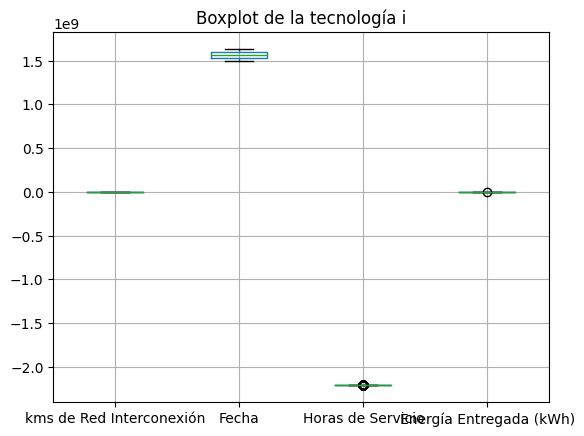

In [38]:
df_i.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).boxplot().set_title('Boxplot de la tecnología i')
plt.show()

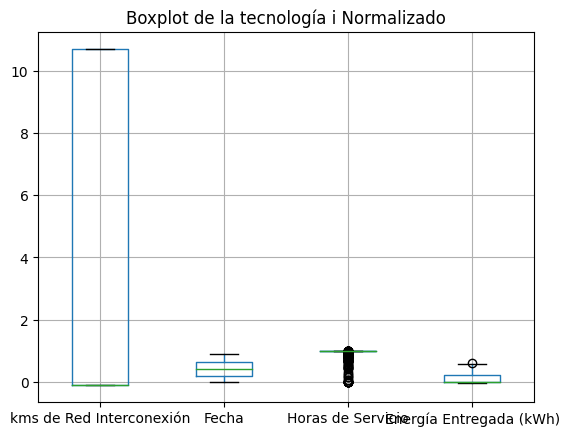

In [39]:
df_i_n.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).boxplot().set_title('Boxplot de la tecnología i Normalizado')
plt.show()

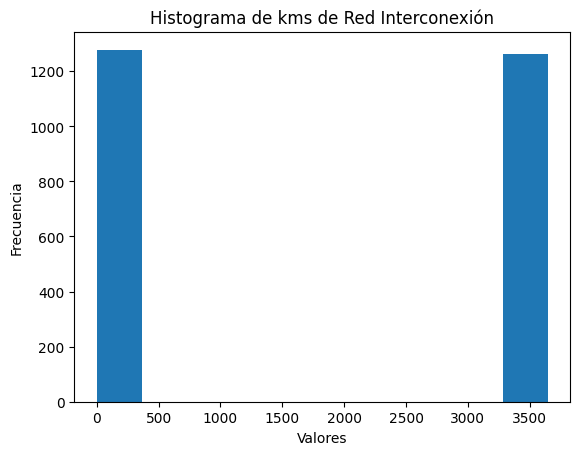

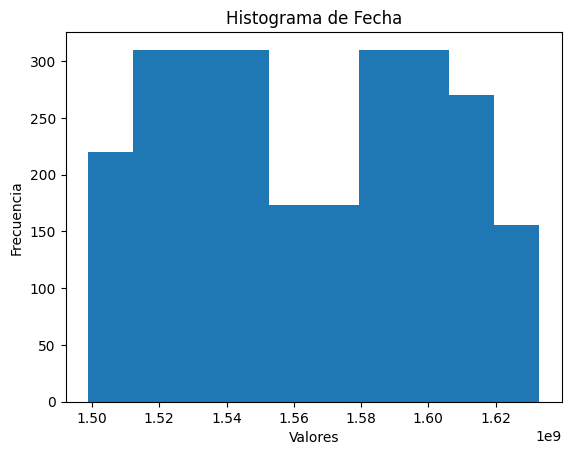

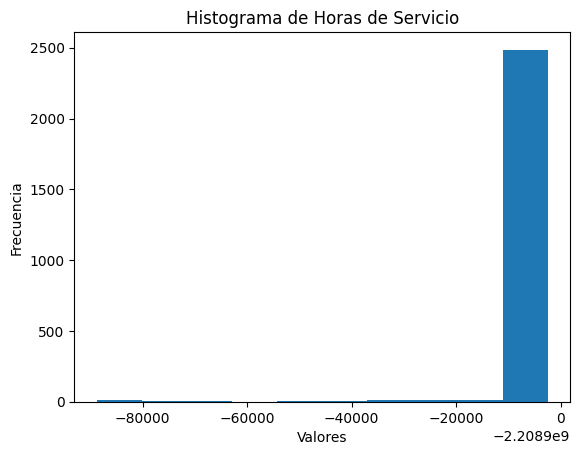

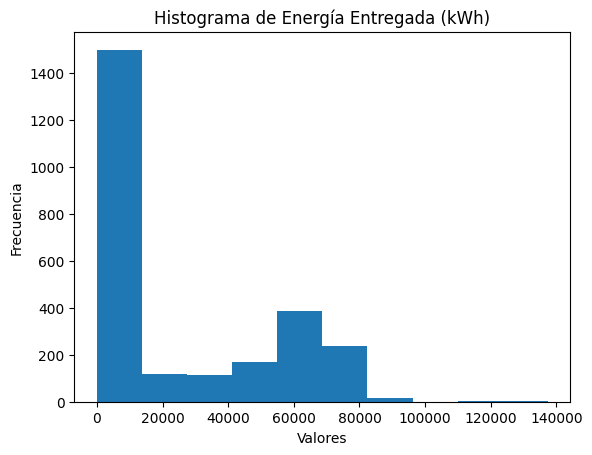

In [40]:
for col in df_i.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).columns:
    plt.hist(df_i[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

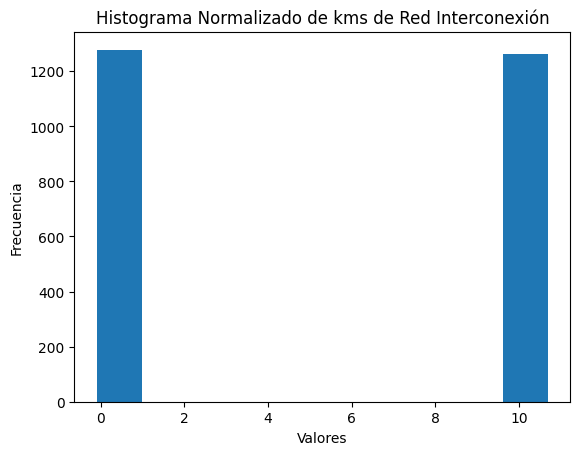

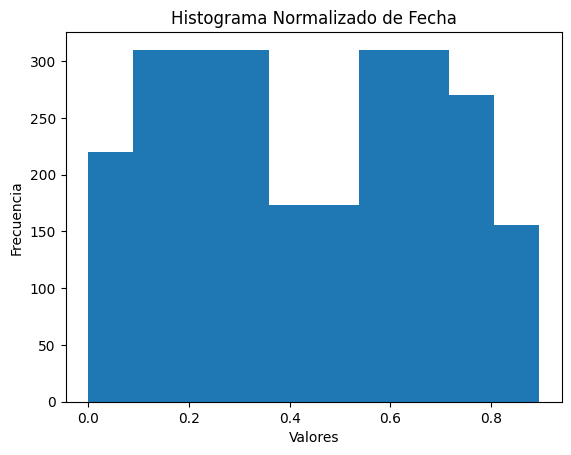

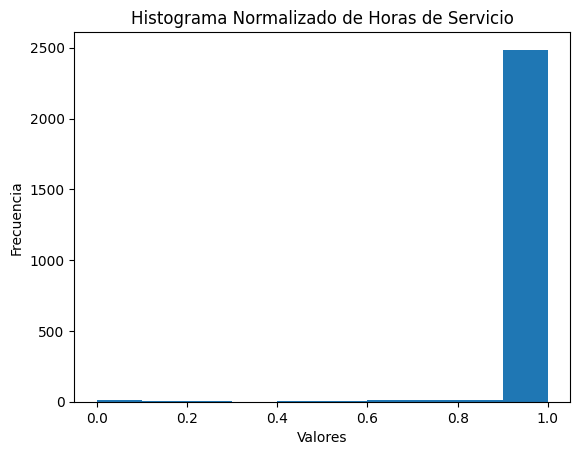

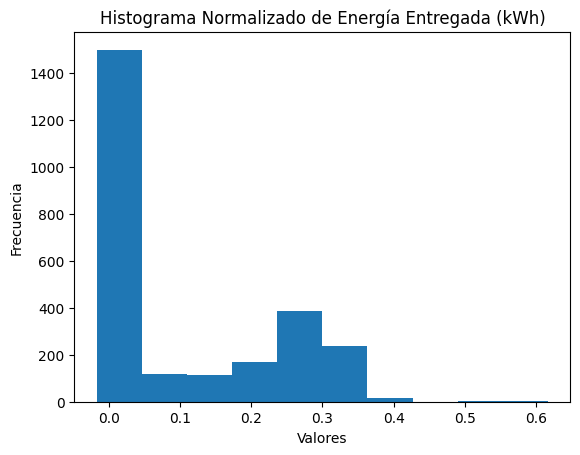

In [41]:
for col in df_i_n.drop(['Departamento','Municipio','Capacidad (kW)', 'Tipo de Tecnología'], axis=1).columns:
    plt.hist(df_i_n[col], bins=10)
    plt.title(f"Histograma Normalizado de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

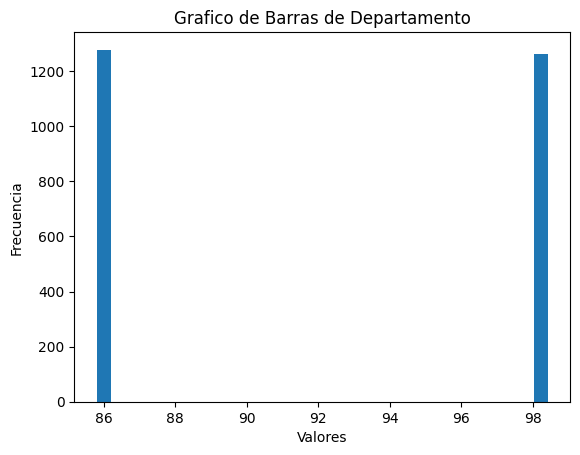

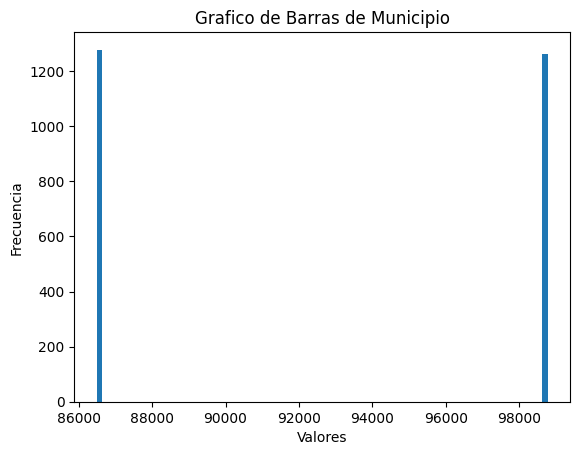

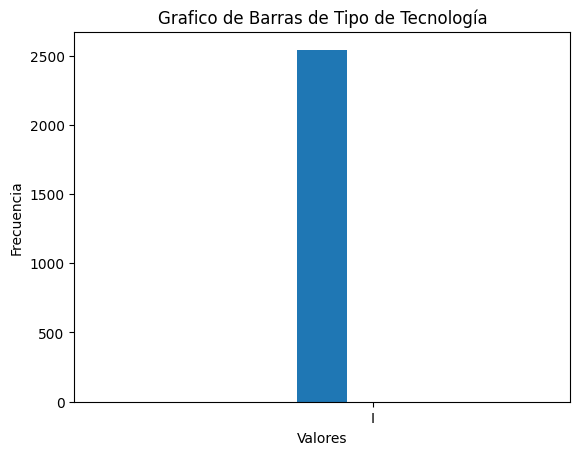

In [42]:
for col in df_i.loc[:,['Departamento','Municipio', 'Tipo de Tecnología']].columns:
    plt.hist(df_i[col], bins=len(df[col].unique()), align='left', rwidth=0.5)
    plt.title(f"Grafico de Barras de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

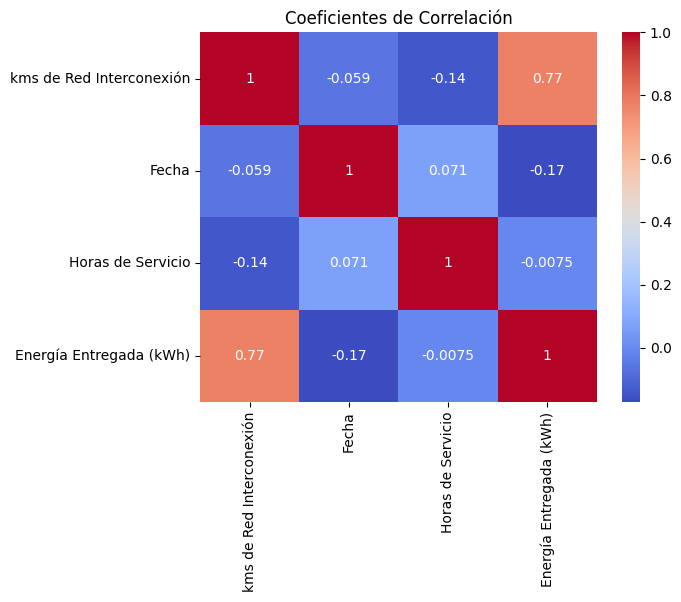

In [43]:
corr_matrix = df_i.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Coeficientes de Correlación')
plt.show()

***

#### 3.1.5: B - Biomasa  <a id='sec3-1-5'></a>

In [44]:
df_b.head()

Tipo de Tecnología  kms de Red Interconexión  Capacidad (kW)   
143550                  B                      3646             NaN  \
144169                  B                      3646             NaN   
144367                  B                      3646             NaN   
145452                  B                      3646             NaN   
145829                  B                      3646             NaN   

               Fecha  Horas de Servicio  Energía Entregada (kWh)   
143550  1.628554e+09      -2.208902e+09                      0.0  \
144169  1.627430e+09      -2.208902e+09                  28399.0   
144367  1.635034e+09      -2.208902e+09                  36502.0   
145452  1.625098e+09      -2.208902e+09                      0.0   
145829  1.627258e+09      -2.208902e+09                      0.0   

        Departamento  Municipio  
143550            99      99001  
144169            99      99001  
144367            99      99001  
145452            99      99001  
145829            99      99001

In [45]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 143550 to 200218
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tipo de Tecnología        274 non-null    object 
 1   kms de Red Interconexión  274 non-null    int64  
 2   Capacidad (kW)            0 non-null      float64
 3   Fecha                     274 non-null    float64
 4   Horas de Servicio         274 non-null    float64
 5   Energía Entregada (kWh)   274 non-null    float64
 6   Departamento              274 non-null    int64  
 7   Municipio                 274 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 19.3+ KB


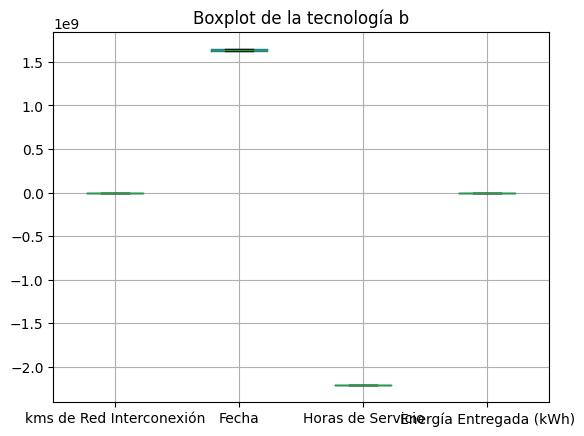

In [46]:
df_b.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).boxplot().set_title('Boxplot de la tecnología b')
plt.show()

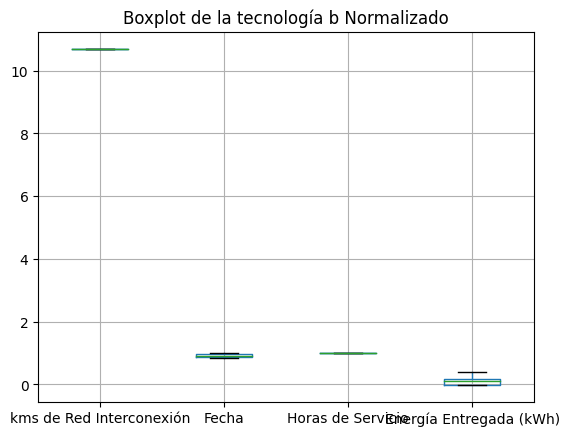

In [47]:
df_b_n.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).boxplot().set_title('Boxplot de la tecnología b Normalizado')
plt.show()

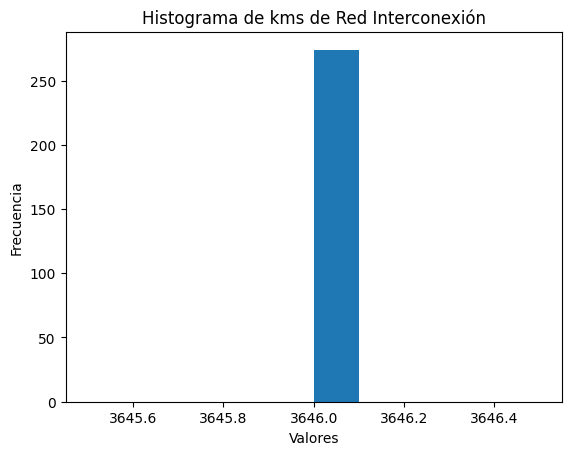

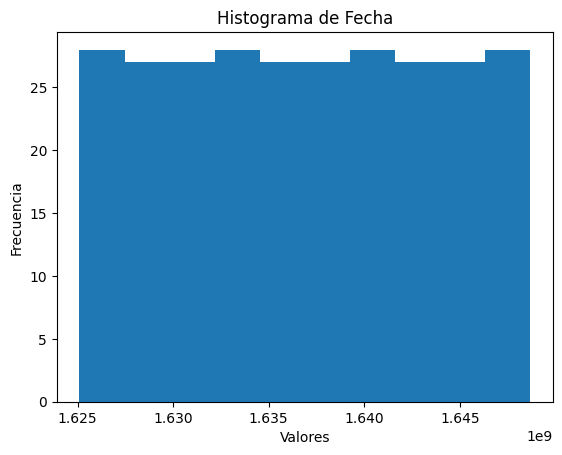

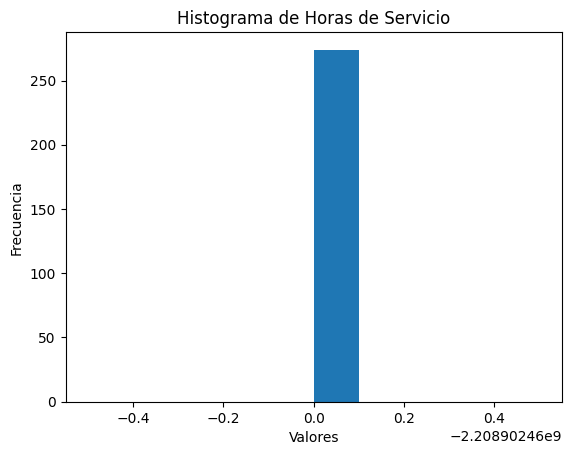

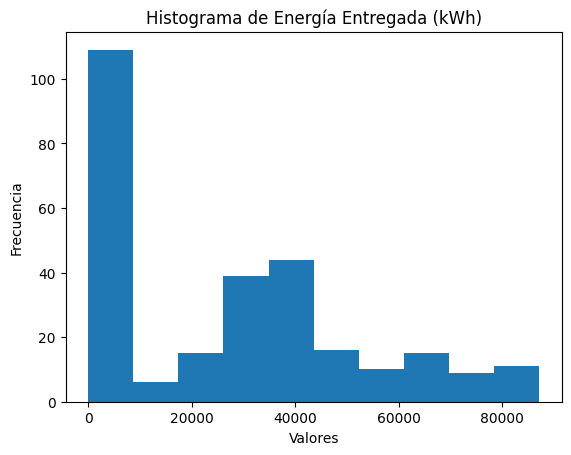

In [48]:
for col in df_b.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).columns:
    plt.hist(df_b[col], bins=10)
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

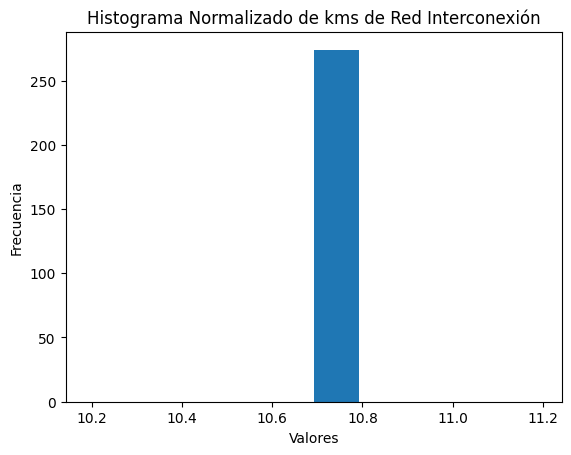

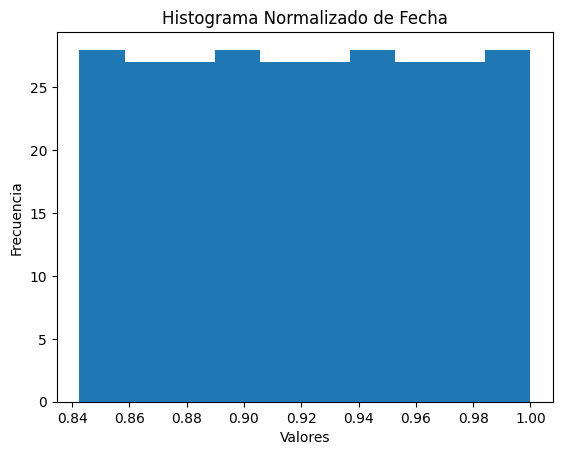

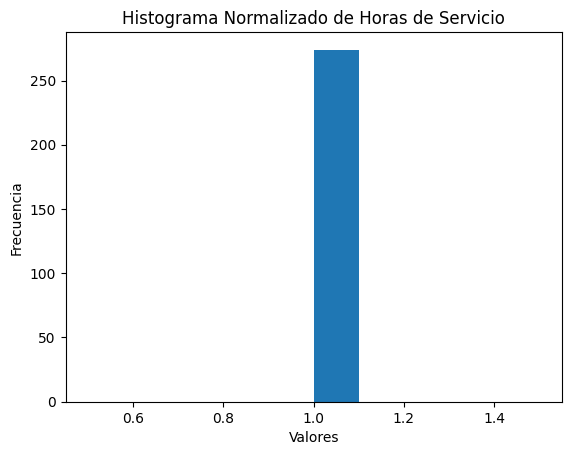

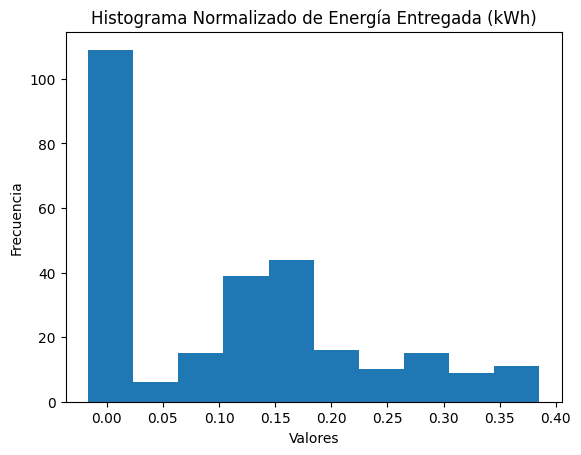

In [49]:
for col in df_b_n.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).columns:
    plt.hist(df_b_n[col], bins=10)
    plt.title(f"Histograma Normalizado de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

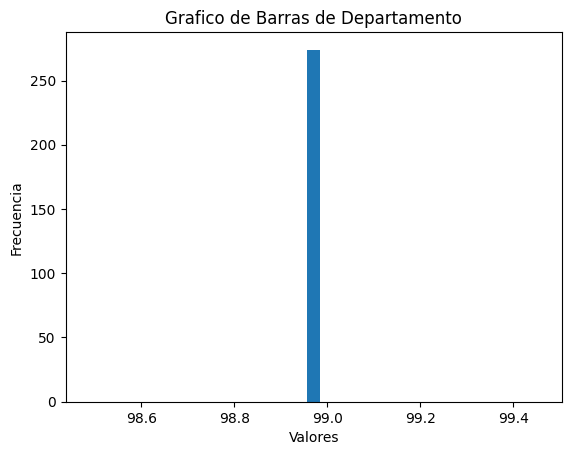

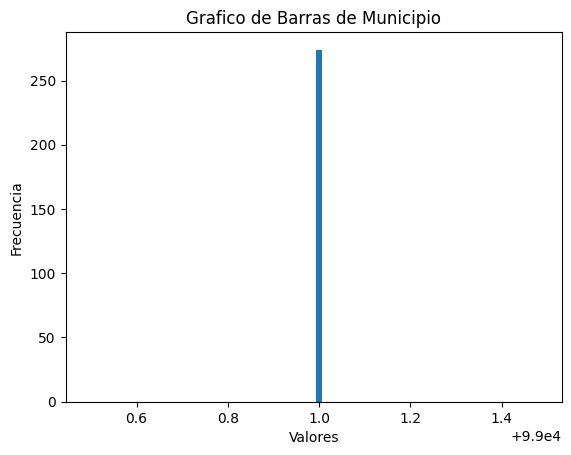

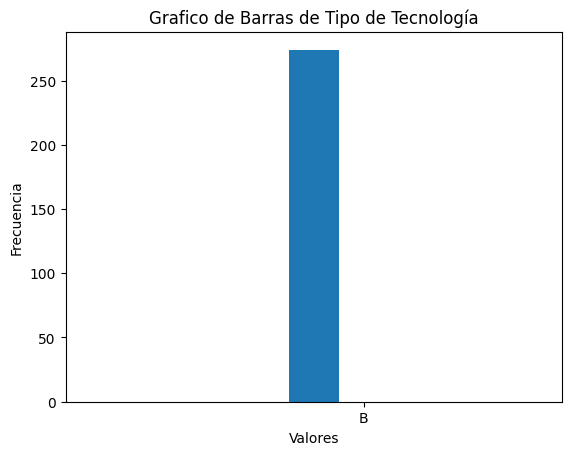

In [50]:
for col in df_b.loc[:,['Departamento','Municipio', 'Tipo de Tecnología']].columns:
    plt.hist(df_b[col], bins=len(df[col].unique()), align='left', rwidth=0.5)
    plt.title(f"Grafico de Barras de {col}")
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

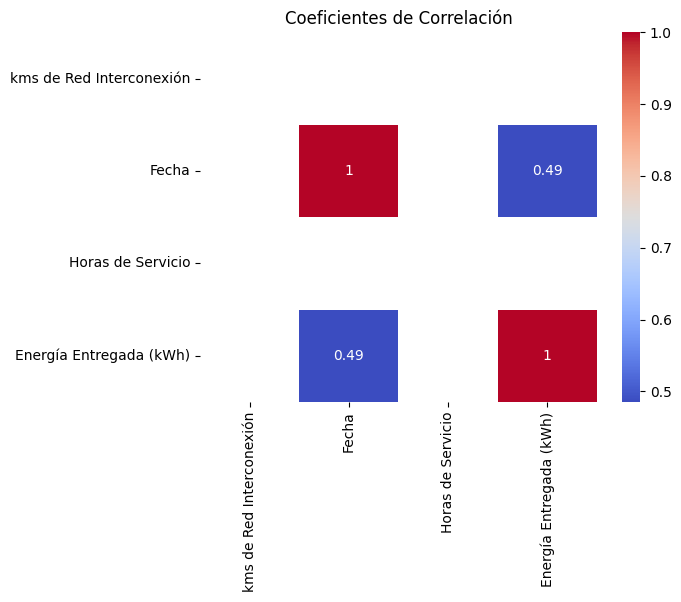

In [51]:
corr_matrix = df_b.drop(['Departamento','Municipio', 'Tipo de Tecnología', 'Capacidad (kW)'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Coeficientes de Correlación')
plt.show()

***

#### 1.6: Conclusiones  <a id='sec3-1-9'></a>

##### Histogramas

Si la forma de los histogramas es la misma cuando se compara el dataset normalizado y sin normalizar, esto sugiere que la distribución de los datos no se ha visto significativamente afectada por la normalización.

La normalización puede cambiar la forma de la distribución de los datos, ya que escala los valores de las características a una escala común. Sin embargo, si la forma de los histogramas es la misma en ambos casos, entonces esto sugiere que la distribución de los datos no cambió significativamente durante el proceso de normalización.

Esto puede ocurrir cuando la distribución de los datos ya era relativamente simétrica y centrada en torno a una media común antes de la normalización, o cuando la normalización utilizada no ha tenido un efecto significativo en la distribución de los datos.

En general, es una buena práctica verificar la distribución de los datos antes y después de la normalización para asegurarse de que la normalización no haya introducido distorsiones significativas en los datos. Si los histogramas son similares, esto sugiere que la normalización no ha tenido un impacto significativo en la forma de la distribución de los datos.

Además de la conclusión de que la distribución de los datos no cambió significativamente durante el proceso de normalización, también se puede concluir que los valores de las características del conjunto de datos tienen una escala común y son comparables entre sí.

La normalización puede ser útil para asegurarse de que las diferentes características de un conjunto de datos estén en una escala común. Esto es especialmente útil en técnicas de aprendizaje automático que utilizan medidas de distancia entre características, como el clustering o la clasificación.

Al tener una escala común, las características pueden compararse y evaluarse en un mismo nivel de importancia en el análisis exploratorio de datos. La normalización puede ser especialmente útil cuando se trabaja con variables que están en diferentes unidades, como peso y altura, o cuando se trabaja con variables que tienen diferentes magnitudes o variabilidades, como ingresos y gastos.

En resumen, además de la conclusión de que la distribución de los datos no cambió significativamente durante el proceso de normalización, se puede concluir que los valores de las características del conjunto de datos están en una escala común y son comparables entre sí.

Cuando hay una variable con muchos datos atípicos en un boxplot de varias variables normalizadas, como es el caso de **_Energía Entregada (kWh)_**, es probable que la escala de la variable esté sesgada o tenga una distribución no normal. Esto puede hacer que los valores extremos sean más evidentes en el gráfico, lo que hace que la mediana y los cuartiles se vean afectados. También es importante analizar por qué hay tantos valores atípicos en la variable y considerar si se deben a errores en la medición o si representan verdaderos valores extremos. Si son errores, puede ser necesario revisar la medición y los datos para corregirlos. Si son valores extremos legítimos, es posible que desee investigar por qué se produjeron y qué implicaciones tienen para su análisis.

##### Matriz de Correlación

La matriz de correlación es una tabla que muestra cómo las variables están relacionadas entre sí. Los valores en la matriz representan la fuerza y la dirección de la relación entre dos variables. Los valores pueden variar entre -1 y 1, donde 1 significa una correlación positiva perfecta, -1 significa una correlación negativa perfecta y 0 significa que no hay correlación.

Si en el mapa de calor generado por la función **sns.heatmap()** entre dos variables diferentes no aparece correlación y se muestra con un color blanco, significa que la correlación entre esas dos variables es cero. En otras palabras, las dos variables no están relacionadas entre sí. El color blanco es el valor predeterminado en el mapa de calor de Seaborn para indicar que no hay correlación.

Es importante tener en cuenta que la falta de correlación no significa necesariamente que las dos variables no tengan ninguna relación entre sí. Es posible que exista una relación no lineal o compleja que no se detecte mediante una simple correlación lineal. Además, la correlación no implica causalidad, por lo que incluso si dos variables están altamente correlacionadas, no se puede asumir que una variable causa la otra. En cualquier caso, el mapa de calor generado por **sns.heatmap()** es una herramienta útil para explorar la relación entre variables en un conjunto de datos.

##### Proceso

Si decides analizar individualmente el comportamiento del dataset según las opciones de una variable categórica en lugar de utilizar técnicas multivariadas como MANOVA, estarás realizando un análisis univariado. El análisis univariado implica examinar una variable a la vez y no considera las relaciones entre las diferentes variables del conjunto de datos.

Aunque el análisis univariado puede ser útil para explorar la distribución de una variable categórica y obtener información sobre cada una de las opciones de esa variable, no proporciona información sobre cómo estas opciones se relacionan con otras variables en el conjunto de datos. Por lo tanto, es posible que se pierda información importante sobre la relación entre la variable categórica y las variables continuas u otras variables categóricas.

En resumen, si bien el análisis univariado puede ser útil para obtener información básica sobre una variable categórica, las técnicas multivariadas como MANOVA permiten un análisis más completo y preciso de la relación entre varias variables categóricas y una variable continua.

Cuando se realiza un análisis univariado, se analiza una variable a la vez y no se tiene en cuenta la relación entre las diferentes variables en el conjunto de datos. Como resultado, es posible que se pierda información importante sobre cómo las variables se relacionan entre sí. Por ejemplo, si se tiene un conjunto de datos con varias variables categóricas y una variable continua, un análisis univariado solo examinaría la relación entre cada variable categórica y la variable continua por separado, sin considerar cómo se relacionan las diferentes variables categóricas entre sí.

Además, el análisis univariado puede llevar a errores en la interpretación de los resultados. Por ejemplo, si se realiza un análisis univariado y se encuentra una relación significativa entre una variable categórica y la variable continua, se podría concluir que esa variable categórica tiene un efecto significativo en la variable continua. Sin embargo, si no se han considerado otras variables categóricas en el análisis, es posible que esta conclusión sea incorrecta o incompleta.

En contraste, el análisis multivariado como MANOVA tiene en cuenta la relación entre varias variables categóricas y una variable continua, lo que permite una interpretación más completa y precisa de los resultados. Además, MANOVA tiene en cuenta la covarianza entre las diferentes variables y proporciona una prueba global de la hipótesis nula de que no hay diferencias significativas entre los grupos.

En resumen, el análisis univariado puede proporcionar información útil sobre una variable categórica individual, pero puede llevar a la pérdida de información importante y errores en la interpretación de los resultados. En cambio, el análisis multivariado como MANOVA proporciona una visión más completa de cómo las variables categóricas se relacionan con la variable continua, lo que permite una interpretación más precisa y completa de los resultados.

***
***

### 3.2 Análisis Multivariado de la Varianza <a id='sec3-2'>

***
***
***

## 4. Otras Visualizaciones <a id='secvisual'></a>


In [ ]:
if not os.path.exists("images"):
    os.mkdir("images")

In [17]:
f = open('resources/colombia.geo.json',)
colombia_states = json.load(f)

state_id_map = {}
for feature in colombia_states['features']:
    feature['id'] = feature['properties']['DPTO']
    state_id_map[feature['id']] = feature['properties']['NOMBRE_DPT']

frecuencias = df['Departamento'].value_counts()
df_depart = pd.DataFrame({'DPTO': frecuencias.index, 'Frecuencia': frecuencias.values})

def formatear_numero(numero):
    return str(numero).zfill(2) if numero < 10 else str(numero)

df_depart['DPTO'] = df_depart['DPTO'].apply(formatear_numero)
df_depart['DPTO'] = df_depart['DPTO'].astype(str)
df_depart['NOMBRE_DPT'] = df_depart['DPTO'].apply(lambda x:state_id_map[x])

fig = px.choropleth(df_depart, geojson=colombia_states, color="Frecuencia",
                    locations="NOMBRE_DPT", featureidkey="properties.NOMBRE_DPT",
                    projection="mercator", title="Mapa de Frecuencias por Departamentos"
                    )

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [11]:
plotly.offline.plot(fig, filename='images/MapaDepartamentos.html')
fig.write_image("images/MapaDepartamentos.svg",format='svg',engine='kaleido')

<img src="images/MapaDepartamentos.svg" alt="Mapa de Frecuencias según los Departamentos" />

***
***
***

## 5. Conclusiones <a id='sec4'></a>

In [13]:
df = px.data.election()
geojson = px.data.election_geojson()

fig = px.choropleth(df, geojson=geojson, color="Bergeron",
                    locations="district", featureidkey="properties.district",
                    projection="mercator")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [14]:
plotly.offline.plot(fig, filename='images/Prueba.html')
fig.write_image("images/Prueba.svg",format='svg',engine='kaleido')

<img src="images/Prueba.svg" alt="Alternative text" />

In [ ]:
#geojson

In [ ]:
#df.head()